<a href="https://colab.research.google.com/github/bb2796/sample-repo/blob/main/PRML4%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
#xをφをに変換する
def calcPhimat(X):
    '''
    This function generates the design matrix Phi from X, the input data

    Parameters
    ----------
    X : 2-D numpy array
        (N,d) numpy array, with X[n, i] = i-th element of x_n

    Returns
    ----------
    Phi : 2-D numpy array
        The design matrix
    '''
    N = len(X)
    if len(np.shape(X)) == 1:
        d = 1
    else:
        d = np.shape(X)[1]
    Phi = np.zeros((N,d+1))
    Phi[:,0] = np.ones(N)
    Phi[:,1:] = np.reshape(X, (N,d))
    return Phi


In [3]:
#マルチラベルの行列を作成
def calcTmat(y, C):
    '''
    This function generates the matrix T from the training label y and the number of classes C

    Parameters
    ----------
    y : 1-D numpy array
        The elements of y should be integers in [0, C-1]
    C : int
        The number of classes

    Returns
    ----------
    T : (len(y), C) numpy array
        T[n, c] = 1 if y[n] == c else 0
    '''
    N = len(y)
    T = np.zeros((N, C))
    for c in range(C):
        T[:, c] = (y == c)
    return T

In [4]:
#ソフトマックス関数
def calcPmat(Theta, Phi):
    '''
    This function generates the matrix P from the weight Theta and the design matrix Phi

    Parameters
    ----------
    Theta : 2-D numpy array
        Matrix representing the weight parameter
    Phi : 2-D numpy array
        The design matrix

    Returns
    ----------
    P : 2-D numpy array
    '''
    P = np.exp( Phi @ (Theta.T) )
    P = P/np.reshape( np.sum(P, axis= 1), (len(Phi),1)  ) 
    return P

In [4]:
#コスト関数
def cost_function(thtvec, Phi, T, lam):
    '''
    This function calculate the loss function and its gradient

    Parameters
    ----------
    thtvec : 1-D numpy array 
        (M*C,) array, which represents the weight parameter Theta, in flattened form
    Phi : 2-D numpy array
        (N, M) array, design matrix
    T : 2-D numpy array
        (N, C) array, where T[n, c] = 1 if y[n] == c else 0
    lam : float
        The regularization constant

    Returns
    ----------
    J : float
        The value of cost function        
    '''
    N, M = np.shape(Phi)
    C = np.shape(T)[1]
    Theta = np.reshape(thtvec, (C, M))
    P = calcPmat(Theta, Phi)
    J = -1.0/N*np.sum(T*np.log(P)) + lam/(2.0*N)*np.linalg.norm(thtvec)**2
    return J

In [5]:
#コスト関数をθに関して微分
def grad_cost_function(thtvec, Phi, T, lam):
    '''
    This function calculates the gradient of the cost function 

    Parameters
    ----------
    See the help for cost_function

    Returns
    ----------
    grad_vec : 2-D array
        The gradient of the cost function with respect to the weight parameter Theta, in flattened form
    '''
    N, M = np.shape(Phi)
    C = np.shape(T)[1]
    Theta = np.reshape(thtvec, (C, M))
    P = calcPmat(Theta, Phi)
    grad_mat = 1.0/N*((P - T).T) @ Phi + lam/N*Theta
    grad_vec = np.reshape(grad_mat, len(thtvec))
    return grad_vec

In [6]:

def hess_cost_function(thtvec, Phi, T, lam):
    '''
    This function calculates the Hessian of the cost function 

    Parameters
    ----------
    See the help for cost_function

    Returns
    ----------
    H : 2-D array
        The hessian
    '''
    N, M = np.shape(Phi)
    C = np.shape(T)[1]
    Theta = np.reshape(thtvec, (C, M))
    P = calcPmat(Theta, Phi)
    tmparr_A = np.reshape(P, (N, C, 1)) * ( np.reshape(np.identity(C), (1, C, C)) - np.reshape(P, (N, 1, C)) )
    tmparr_B = np.reshape(Phi, (N, M, 1)) * np.reshape(Phi, (N, 1, M)) 
    H_tmp = np.einsum('nik,njl->ijkl', tmparr_A, tmparr_B)/N
    H = np.reshape(H_tmp, (C*M, C*M)) + lam/N*np.identity(C*M)
    return H

In [7]:

from scipy.sparse.linalg import LinearOperator

def hessp_cost_function(thtvec, Phi, T, lam):
    '''
    This function returns the function representing the product of Hessian and a given vector

    Parameters
    ----------
    See the help for cost_function

    Returns
    ----------
    A : scipy.sparse,linalg.LinearOperator object
        A linear operator representing the Hessian of the cost function
    '''
    N, M = np.shape(Phi)
    C = np.shape(T)[1]
    Theta = np.reshape(thtvec, (C, M))
    P = calcPmat(Theta, Phi)
    def hp(v):
        V = np.reshape(v, (C, M))
        tmp = Phi @ V.T
        tmp = tmp - np.reshape(np.sum(P*tmp, axis=1), (N, -1))
        product = ((P*tmp).T @ Phi)/N + lam/N*V
        product = product.flatten()
        return product
    A = LinearOperator((C*M, C*M), matvec=hp)
    return A

In [8]:

def minimize_GD(func, x0, grad, alpha=0.01, maxiter=1e4, ftol=1e-5):
    '''
    This function minimizes the given function using gradient descent method

    Parameters
    ----------
    func : callable
        Function to be minimized (real-valued)
    x0 : 1-D array
        Initial value of the variable
    grad : callable
        The gradient of func (returns 1-D array)
    alpha : float
        Learning rate
    maxiter : int
        Maximum number of iteration
    ftol : float
        The threshold for stopping criterion. If the change of the value of function is smaller than this value, the iteration stops.

    Returns
    ----------
    result : dictionary
        result['x'] ... variable, result['nit'] ... the number of iteration, result['func']...the value of the function, result['success']... whether the minimization is successful or not
    '''
    x = x0
    nit = 0
    while nit < maxiter:
        xold = x
        x = x - alpha*grad(x)
        nit += 1
        if abs(func(x) - func(xold)) < ftol:
            break
    success = (nit < maxiter)
    return {'x': x, 'nit':nit, 'func':func(x), 'success':success}

In [9]:

def minimize_newton(func, x0, grad, hess, maxiter=1e4, ftol=1e-5):
    '''
    This function minimizes the given function using Newton method

    Parameters
    ----------
    func : callable
        Function to be minimized (real-valued)
    x0 : 1-D array
        Initial value of the variable
    grad : callable
        The gradient of func (returns 1-D array)
    hess: callable
        The hessian of func (returns 2-D array)
    maxiter : int
        Maximum number of iteration
    ftol : float
        The threshold for stopping criterion. If the change of the value of function is smaller than this value, the iteration stops.

    Returns
    ----------
    result : dictionary
        result['x'] ... variable, result['nit'] ... the number of iteration, result['func']...the value of the function, result['success']... whether the minimization is successful or not
    '''
    x = x0
    nit = 0
    while nit < maxiter:
        xold = x
        x = x - np.linalg.solve(hess(x), grad(x))
        nit += 1
        if abs(func(x) - func(xold)) < ftol:
            break
    success = (nit < maxiter)
    return {'x': x, 'nit':nit, 'func':func(x), 'success':success}

In [10]:

from scipy.sparse.linalg import cg

def minimize_ncg(func, x0, grad, hessp, maxiter=1e4, ftol=1e-5):
    '''
    This function minimizes the given function using Newton-CG method

    Parameters
    ----------
    func : callable
        Function to be minimized (real-valued)
    x0 : 1-D array
        Initial value of the variable
    grad : callable
        The gradient of func (returns 1-D array)
    hessp: callable
        A function which returns scipy.sparse.linalg.LinearOperator object representing Hessian
    maxiter : int
        Maximum number of iteration
    ftol : float
        The threshold for stopping criterion. If the change of the value of function is smaller than this value, the iteration stops.

    Returns
    ----------
    result : dictionary
        result['x'] ... variable, result['nit'] ... the number of iteration, result['func']...the value of the function, result['success']... whether the minimization is successful or not
    '''
    x = x0
    nit = 0
    while nit < maxiter:
        xold = x
        x = x - cg(A=hessp(x), b=grad(x))[0]
        nit += 1
        if abs(func(x) - func(xold)) < ftol:
            break
    success = (nit < maxiter)
    return {'x': x, 'nit':nit, 'func':func(x), 'success':success} 

In [11]:

def minimize(func, x0, method, grad, hess=None, hessp=None, alpha=None, maxiter=1e4, ftol=1e-5):
    '''
    This function minimizes the given function using the method speicified by user.

    Parameters
    ----------
    func : callable
        Function to be minimized (real-valued)
    x0 : 1-D array
        Initial value of the variable
    method : string
        One of 'gd', 'newton', 'newton-cg'.
    grad : callable
        The gradient of func (returns 1-D array)
    hess : callable
        The hessian of func (returns 2-D array). Required when method='newton'
    hessp: callable
        A function which returns scipy.sparse.linalg.LinearOperator object representing Hessian. Required when method='newton-cg'
    alpha : float
        Learning rate
    maxiter : int
        Maximum number of iteration
    ftol : float
        The threshold for stopping criterion. If the change of the value of function is smaller than this value, the iteration stops.

    Returns
    ----------
    result : dictionary
        result['x'] ... variable, result['nit'] ... the number of iteration, result['func']...the value of the function, result['success']... whether the minimization is successful or not
    '''
    if method == 'gd':
        if alpha is None:
            print("Gradient descent needs a learning rate parameter alpha.")
            return
        else:
            return minimize_GD(func, x0, grad, alpha, maxiter, ftol)
    elif method == 'newton':
        if hess is None:
            print("Newton-Raphson method requires the hessian.")
            return
        else:
            return minimize_newton(func, x0, grad, hess, maxiter, ftol)
    elif method == 'newton-cg':
        if hessp is None:
            print("Newton-CG method requires the hessian-product function.")
            return
        else:
            return minimize_ncg(func, x0, grad, hessp, maxiter, ftol)
    else:
        print("method should be one of gd, newton, newton-cg")

In [12]:

class LogisticClf:
    def __init__(self, C, lam):
        self.C = C  # the number of labels
        self.lam = lam #regularization parameter
        self.Theta = None

    def fit(self, X, y, method='NR', alpha=None, maxiter=1e4, ftol=1e-5, show_message=False):
        '''
        Parameters
        ----------
        X : 1-D or 2-D numpy array
            (N,) or (N, d) array, representing the training input data
        y : 1-D numpy arra
            (N,) array, representing training labels
        '''
        Phi = calcPhimat(X)
        T = calcTmat(y, self.C)
        N, M = np.shape(Phi)

        tht0 = np.zeros(M*self.C)
        time_start = time.time()
        result = minimize(func=lambda x : cost_function(x, Phi, T, self.lam), 
                          x0=tht0, 
                          method=method,
                          grad=lambda x : grad_cost_function(x, Phi, T, self.lam),
                          hess=lambda x : hess_cost_function(x, Phi, T, self.lam),
                          hessp = lambda x : hessp_cost_function(x, Phi, T, self.lam),
                          alpha=alpha,
                          maxiter=maxiter,
                          ftol=ftol
                         )
        time_end = time.time()
        if show_message:
            print(result['success'])
            print(f"nit: {result['nit']}")
            print(f"calcualtion time : {time_end - time_start}seconds")
        self.Theta = np.reshape(result['x'], (self.C, M))

    def predict_proba(self, X):
        '''
        Parameters
        ----------
        X : 1-D or 2-D numpy array
            (N,) or (N, d) array, representing the training input data
        Returns
        ----------
        proba : 2-D numpy arra
            (len(X), self.C) array, where proba[n, c] represents the probability that the n-th instance belongs to c-th class
        '''
        return calcPmat(self.Theta, calcPhimat(X))

    def predict(self, X):
        '''
        Parameters
        ----------
        X : 1-D or 2-D numpy array
            (N,) or (N, d) array, representing the training input data
        Returns
        ----------
        classes : 1-D numpy arra
            (len(X), ) array, where classes[n] represents the predicted class to which the n-th instance belongs
        '''
        tmp = self.predict_proba(X)
        return np.argmax(tmp, axis=1 )

In [14]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [15]:
X, y = datasets.make_blobs(n_samples=200, n_features=2, centers=3)

In [16]:
def get_meshgrid(x, y, nx, ny, margin=0.1):
    x_min, x_max = (1 + margin) * x.min() - margin * x.max(), (1 + margin) * x.max() - margin * x.min()
    y_min, y_max = (1 + margin) * y.min() - margin * y.max(), (1 + margin) * y.max() - margin * y.min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    return xx, yy

def plot_result(ax, clf, xx, yy, X, t):
    Z = (clf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.7)
    ax.scatter(X[:,0], X[:,1], c=t, edgecolor='k')

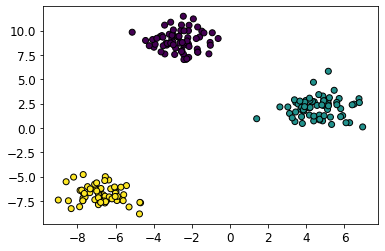

In [19]:
X, t = datasets.make_blobs(n_samples=200, n_features=2, centers=3, random_state=42)
plt.scatter(X[:,0], X[:,1], c=t, edgecolor='k')
plt.show()

xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)

In [21]:
digits = datasets.load_digits()
dat_train, dat_test, label_train, label_test = train_test_split(digits.data, digits.target, test_size=0.25)

True
nit: 693
calcualtion time : 0.16589045524597168seconds


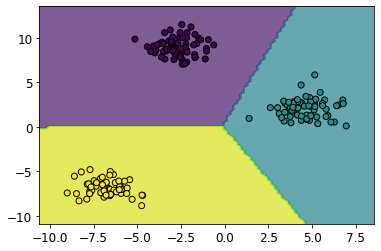

In [22]:
clf = LogisticClf(C = 3, lam = 1.0)
clf.fit(X, t, show_message=True, method='gd', alpha=0.01)
ax = plt.subplot(111)
plot_result(ax, clf, xx, yy, X, t)

True
nit: 8
calcualtion time : 0.00934290885925293seconds


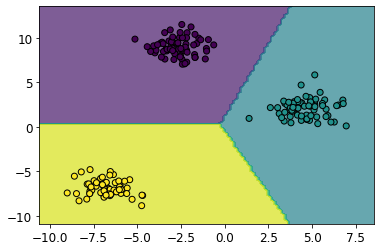

In [23]:
clf = LogisticClf(C = 3, lam = 1.0)
clf.fit(X, t, show_message=True, method='newton')
ax = plt.subplot(111)
plot_result(ax, clf, xx, yy, X, t)

True
nit: 8
calcualtion time : 0.014476776123046875seconds


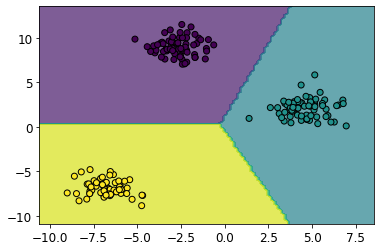

In [24]:
clf = LogisticClf(C = 3, lam = 1.0)
clf.fit(X, t, show_message=True, method='newton-cg')
ax = plt.subplot(111)
plot_result(ax, clf, xx, yy, X, t)

In [25]:
digits = datasets.load_digits()
dat_train, dat_test, label_train, label_test = train_test_split(digits.data, digits.target, test_size=0.25)

print(f"Training data : {len(dat_train)}")
print(f"Test data : {len(dat_test)}")
print(f"Input dimension : {dat_train.shape[1]}")

Training data : 1347
Test data : 450
Input dimension : 64


In [26]:
def show_result_digit(clf):
    label_test_pred = clf.predict(dat_test)
    print(f"train accuracy score: {accuracy_score(label_train, clf.predict(dat_train))}")
    print(f"test accuracy score: {accuracy_score(label_test, label_test_pred)}")

In [27]:
clf = LogisticClf(C=10, lam=1.0)
clf.fit(dat_train, label_train, method='gd', alpha=0.01, show_message=True)
show_result_digit(clf)

True
nit: 1977
calcualtion time : 7.489727258682251seconds
train accuracy score: 0.9992576095025983
test accuracy score: 0.9688888888888889


In [28]:
clf = LogisticClf(C=10, lam=1.0)
clf.fit(dat_train, label_train, method='newton', show_message=True)
show_result_digit(clf)

True
nit: 10
calcualtion time : 17.678614854812622seconds
train accuracy score: 1.0
test accuracy score: 0.9533333333333334


In [29]:
clf = LogisticClf(C=10, lam=1.0)
clf.fit(dat_train, label_train, method='newton-cg', show_message=True)
show_result_digit(clf)

True
nit: 10
calcualtion time : 1.6850109100341797seconds
train accuracy score: 1.0
test accuracy score: 0.9533333333333334


In [30]:
lams = [0.03, 1.0, 30.0]

for lam in lams:
    print(f"lambda = {lam}")
    clf = LogisticClf(C=10, lam=lam)
    clf.fit(dat_train, label_train, method='newton-cg', show_message=True)
    show_result_digit(clf)

lambda = 0.03
True
nit: 12
calcualtion time : 5.794589996337891seconds
train accuracy score: 1.0
test accuracy score: 0.9511111111111111
lambda = 1.0
True
nit: 10
calcualtion time : 1.598273515701294seconds
train accuracy score: 1.0
test accuracy score: 0.9533333333333334
lambda = 30.0
True
nit: 7
calcualtion time : 0.4609184265136719seconds
train accuracy score: 0.9992576095025983
test accuracy score: 0.9644444444444444
